# Mini atlast test notebook

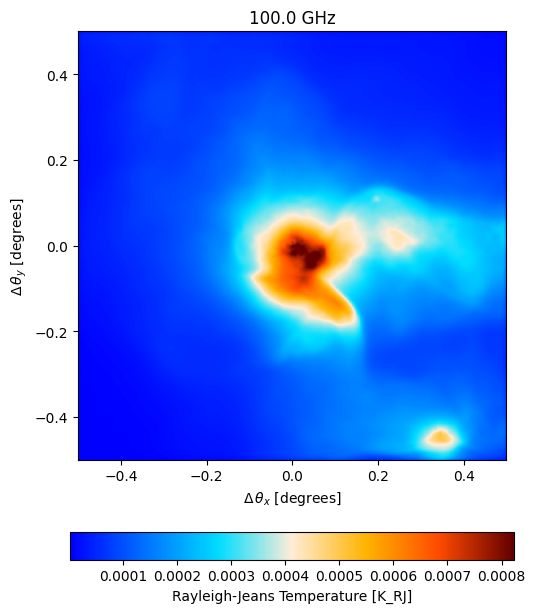

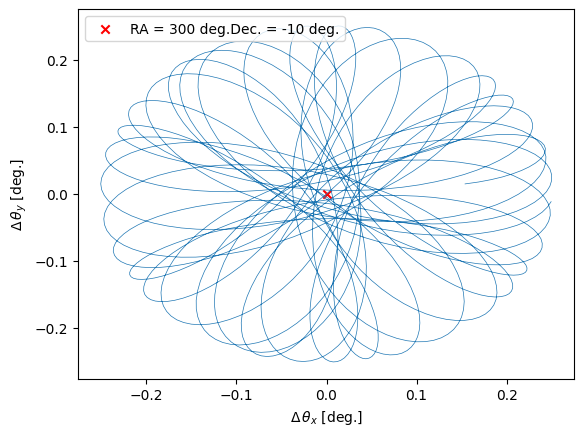

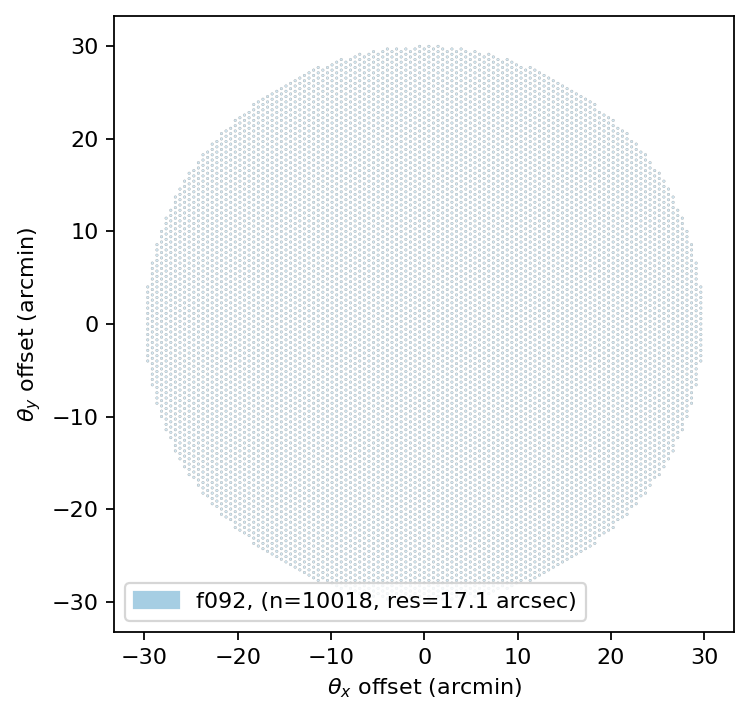

In [1]:
import maria
from maria.instrument import Band

map_filename = maria.io.fetch("maps/big_cluster.fits")

input_map = maria.map.read_fits(filename=map_filename,
                    width=1., #degrees
                    index=1,
                    center=(300, -10), #RA and Dec in degrees
                    units ='Jy/pixel'
                    )
input_map.to(units="K_RJ").plot()

plan = maria.get_plan(scan_pattern="daisy",
            scan_options={"radius": 0.25, "speed": 0.5}, # in degrees
            duration=60, # in seconds
            # sample_rate=225, # in Hz
            sample_rate=25, # in Hz FOR DEBUGGING!
            start_time = "2022-08-10T06:00:00",
            scan_center=(300, -10),
            frame="ra_dec")

plan.plot()

f090 = Band(center=92, # in GHz
            width=40.0,
            knee=1,
            sensitivity=6e-5) # in K sqrt(s)

array = {"field_of_view": 1.0, "bands": [f090], "primary_size": 50, "beam_spacing": 2} # AtLAST

instrument = maria.get_instrument(array=array)
instrument.plot()

## Simulate

2025-01-16 10:22:23.190 INFO: Initialized base in 2137 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
2025-01-16 10:22:29.168 INFO: Initialized atmosphere in 5957 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


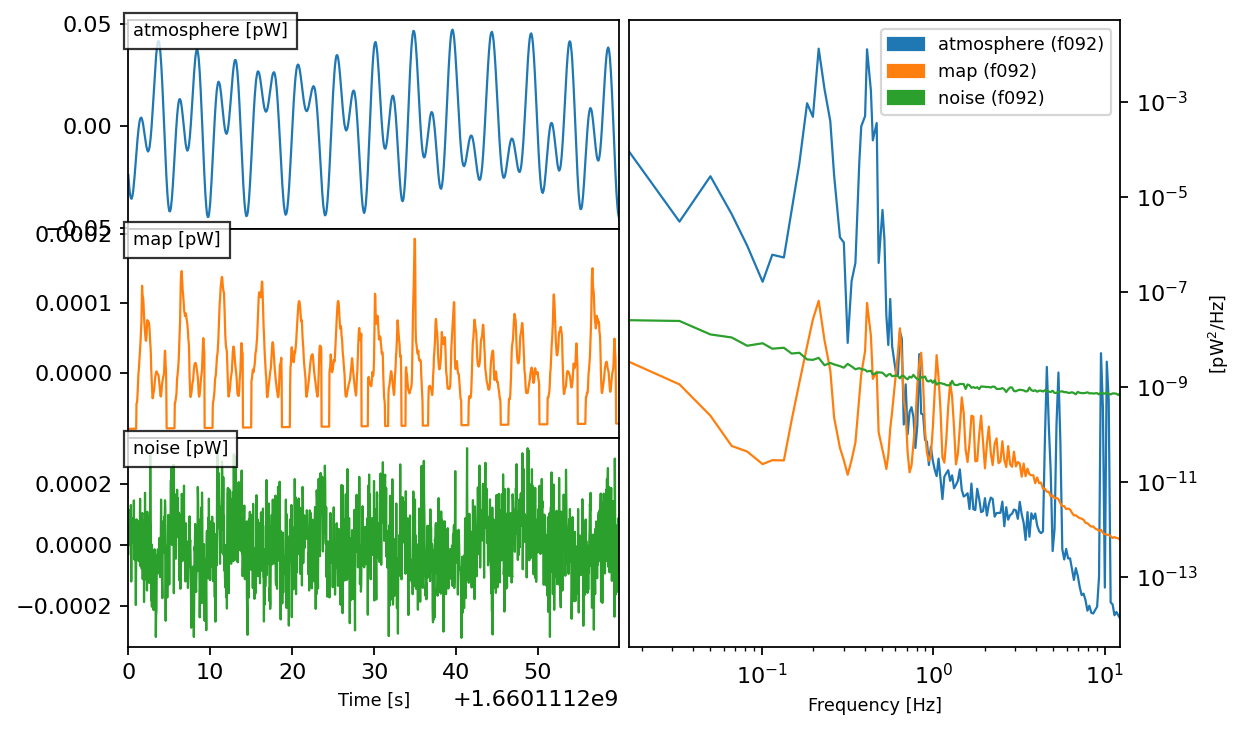

In [2]:
sim_truthmap = maria.Simulation(
            instrument, 
            plan=plan,
            site="llano_de_chajnantor", # green_bank
            map=input_map,
            # noise=False,
            atmosphere="2d",
            # cmb="generate",
        )

tod_truthmap = sim_truthmap.run()

# Plot TODs:
tod_truthmap.plot()

Running mapper (f092): 100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


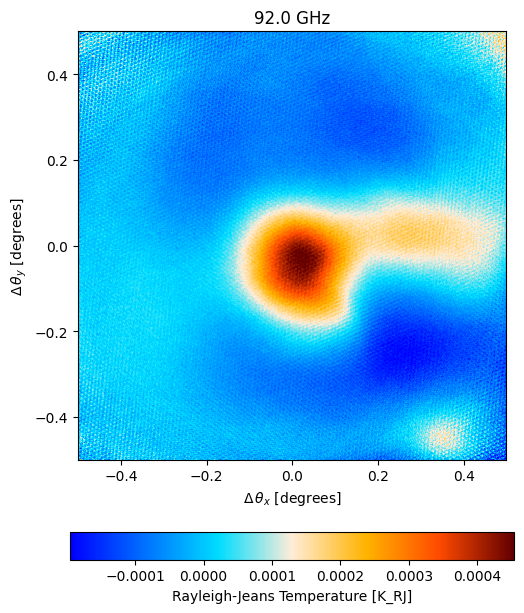

In [3]:
from maria.mappers import BinMapper
import numpy as np

mapper = BinMapper((300, -10),
                frame="ra_dec",
                width=1.,
                height=1.,
                resolution=np.degrees(np.nanmin(instrument.dets.fwhm[0]))/4.,
                tod_preprocessing={
                        # "window": {"name": "hamming"},
                        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
                        "remove_modes": {"modes_to_remove": [0]},
                        "despline": {"knot_spacing": 5},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                )

mapper.add_tods(tod_truthmap)
output_map = mapper.run()

output_map.plot()

In [5]:
output_map.data.shape

(1, 1, 841, 841)

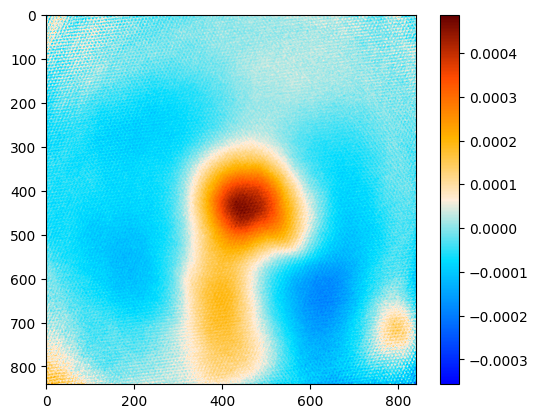

In [9]:
import matplotlib.pyplot as plt
cmb_cmap = plt.get_cmap('cmb')

plt.imshow(output_map.data[0,0], cmap=cmb_cmap)
plt.colorbar()